In [1]:
!pip install -q pyspellchecker # Spell Checker
!pip install -q ktrain # Training Framework
!pip3 install -q git+https://github.com/amaiya/eli5@tfkeras_0_10_1 # Explainability Module

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.3/25.3 MB 45.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 70.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 77.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.8/468.8 kB 51.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
import xgboost as xgb
from sklearn.model_selection import train_test_split
from transformers import AutoModel, AutoTokenizer
import tensorflow as tf
import tensorflow.keras.backend as K
import lightgbm as lgb
import warnings
from PIL import Image
from spellchecker import SpellChecker
from tensorflow.keras import activations

warnings.filterwarnings("ignore")

In [17]:
Task1_Train = pd.read_json("/content/training.json", lines=True)
Task1_Test = pd.read_json("/content/validation_data.json", lines=True)

In [18]:
Task1_Train.sample(1)

,text,label,id
13593,In my judgment this case requires the applicat...,0,13593


In [7]:
i = 0
for index, row in Task1_Test.iterrows():
    text = row['text'].encode('ascii', 'ignore').decode('utf-8')
    Task1_Train['text'][i] = text
    i += 1

i = 0
for index, row in Task1_Test.iterrows():
    text = row['text'].encode('ascii', 'ignore').decode('utf-8')
    Task1_Test['text'][i] = text
    i += 1

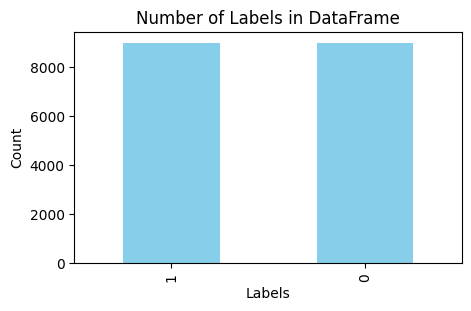

In [19]:
labels_counts = Task1_Train['label'].value_counts()

plt.figure(figsize=(5, 3))
labels_counts.plot(kind='bar', color='skyblue')
plt.title('Number of Labels in DataFrame')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.show()

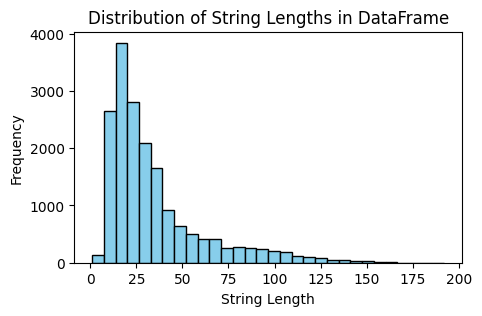

In [20]:
string_lengths = Task1_Train['text'].apply(lambda x: len(str(x).split())).values

# Plotting the string lengths
plt.figure(figsize=(5, 3))
plt.hist(string_lengths, bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of String Lengths in DataFrame')
plt.xlabel('String Length')
plt.ylabel('Frequency')
plt.show()

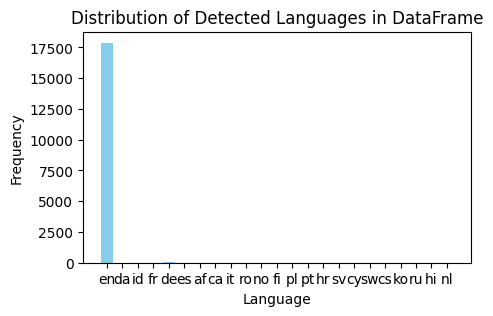

In [21]:
from langdetect import detect
from collections import Counter

def detect_language(text):
    try:
        return detect(text)
    except:
        return 'unknown'

# Create an array of detected languages
language_counts = Task1_Train['text'].apply(detect_language).values

# Count the occurrences of each language
language_counter = Counter(language_counts)

# Plotting the language counts
plt.figure(figsize=(5, 3))
plt.bar(language_counter.keys(), language_counter.values(), color='skyblue')
plt.title('Distribution of Detected Languages in DataFrame')
plt.xlabel('Language')
plt.ylabel('Frequency')
plt.show()

In [22]:
language_counter

Counter({'en': 17880,
         'da': 3,
         'id': 1,
         'fr': 13,
         'de': 31,
         'es': 4,
         'af': 12,
         'ca': 3,
         'it': 13,
         'ro': 12,
         'no': 4,
         'fi': 1,
         'pl': 1,
         'pt': 7,
         'hr': 2,
         'sv': 4,
         'cy': 2,
         'sw': 1,
         'cs': 2,
         'ko': 1,
         'ru': 1,
         'hi': 1,
         'nl': 1})

# Training The Actual Model

In [23]:
X_train, X_validation, y_train, y_validation = train_test_split(Task1_Train['text'], Task1_Train['label'], test_size=0.15, random_state = 44)

In [25]:
!nvidia-smi

Fri Jan  5 15:57:02 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P0              29W /  70W |   4213MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [27]:
import ktrain
from ktrain import text

TextTransformer = text.Transformer('distilbert-base-uncased', maxlen=90, classes = ['0','1'])
train = TextTransformer.preprocess_train(X_train.tolist(), y_train.tolist())
validation = TextTransformer.preprocess_test(X_validation.tolist(), y_validation.tolist())

model = TextTransformer.get_classifier()

learner = ktrain.get_learner(model, train_data=train, val_data=validation, batch_size=16)

preprocessing train...
language: en
train sequence lengths:
	mean : 35
	95percentile : 96
	99percentile : 129


Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 35
	95percentile : 97
	99percentile : 133


In [28]:
learner.autofit(2e-5)

early_stopping automatically enabled at patience=5
reduce_on_plateau automatically enabled at patience=2


begin training using triangular learning rate policy with max lr of 2e-05...
Epoch 1/1024
957/957 [==============================] - 177s 172ms/step - loss: 0.1475 - accuracy: 0.9478 - val_loss: 0.0825 - val_accuracy: 0.9693
Epoch 2/1024
957/957 [==============================] - 163s 170ms/step - loss: 0.0492 - accuracy: 0.9831 - val_loss: 0.0723 - val_accuracy: 0.9756
Epoch 3/1024
957/957 [==============================] - 161s 168ms/step - loss: 0.0238 - accuracy: 0.9925 - val_loss: 0.0771 - val_accuracy: 0.9770
Epoch 4/1024
957/957 [==============================] - ETA: 0s - loss: 0.0124 - accuracy: 0.9965
Epoch 00004: Reducing Max LR on Plateau: new max lr will be 1e-05 (if not early_stopping).
957/957 [==============================] - 161s 168ms/step - loss: 0.0124 - accuracy: 0.9965 - val_loss: 0.0840 - val_accuracy: 0.9778
Epoch 5/1024
957/957 [==========================

## Evaluation

In [29]:
learner.validate(class_names=TextTransformer.get_classes())

85/85 [==============================] - 10s 98ms/step
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      1358
           1       0.98      0.97      0.98      1342

    accuracy                           0.98      2700
   macro avg       0.98      0.98      0.98      2700
weighted avg       0.98      0.98      0.98      2700



array([[1326,   32],
       [  34, 1308]])

In [30]:
learner.view_top_losses(n = 5, preproc=TextTransformer)

85/85 [==============================] - 8s 96ms/step
----------
id:414 | loss:6.26 | true:1 | pred:0)

----------
id:915 | loss:6.03 | true:0 | pred:1)

----------
id:188 | loss:4.99 | true:0 | pred:1)

----------
id:2209 | loss:4.9 | true:0 | pred:1)

----------
id:1864 | loss:4.82 | true:0 | pred:1)



## Explainability
###### Mainly Implemented Using LIME implemented with eli5

In [63]:
!pip install git+https://github.com/amaiya/eli5-tf

  Cloning https://github.com/amaiya/eli5-tf to /tmp/pip-req-build-a7f1vc19
  Running command git clone --filter=blob:none --quiet https://github.com/amaiya/eli5-tf /tmp/pip-req-build-a7f1vc19
  Resolved https://github.com/amaiya/eli5-tf to commit 708f4bd884c3a79bc96e0f4263b103decd21dc00
  Preparing metadata (setup.py) ... done


In [ ]:
predictor = ktrain.get_predictor(learner.model, preproc = TextTransformer)

In [57]:
predictor.predict_proba('Hello My Name is Ahmed El-Sayed')

array([0.00828309, 0.9917169 ], dtype=float32)

In [58]:
predictor.get_classes()

['0', '1']

In [62]:
predictor.explain(Task1_Train['text'][0])

## Generating Predictions

In [ ]:
with open('submission.json', 'w') as json_file:
    for i in range(len(Task1_Test)):
        number = str(Task1_Test['id'][i])
        predictionsDictionary = {'index': int(number), 'prediction': int(Results1['Final Preds'][i])}
        json.dump(predictionsDictionary, json_file)
        json_file.write('\n')

## Ensembling Via Hard Voting

In [ ]:
Roberta = pd.read_json("/content/submission.json", lines=True)
XLMRoberta = pd.read_json("/content/submission1.json", lines=True)
DistilBERT = pd.read_json("/content/submission2.json", lines=True)